In [1]:
import numpy as np
import pandas as pd
from io import BytesIO
import requests
from PIL import Image
import sklearn.svm as skl_svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import sklearn.linear_model as skl_lm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter
from collections import Counter


Các bước xử lí trước khi dự đoán

In [2]:
df = pd.read_csv('pixel_dataframe2.csv')
df['pixel_matrix'] = df['pixel_matrix'].apply(lambda x: np.array([int(number) for number in x.split()]))
df['Genre'] = df['Genre'].apply(lambda x: x.split(sep=', '))

In [3]:
# đọc ảnh
def show_image(array):
    array = np.array(array)
    array = array.astype(np.uint8)
    array = array.reshape((60,40))

    # Tạo đối tượng Image từ mảng
    new_image = Image.fromarray(array)

    # Hiển thị ảnh
    # new_image.show()
    return new_image

In [4]:
# lật ngược ảnh theo chiều ngang
def flip_image(array):
    array = np.array(array)
    array = array.astype(np.uint8)
    array = array.reshape((60,40))
    flipped_image =  np.flip(array, axis=1)
    # print(flip_image)
    new_image = Image.fromarray(flipped_image)

    # Hiển thị ảnh
    # new_image.show()
    return new_image


In [5]:
# lấy 1 phần ảnh
# VD:crop_image(np.array(a), 15,10,30,20)
def crop_image(array, x = 15, y = 10, width = 30, height = 20):
    array = np.array(array)
    array = array.astype(np.uint8)
    array = array.reshape((60,40))
    cropped_image = array[y:y+height, x:x+width]  # Cắt ảnh thành vùng quan tâm
    new_image = Image.fromarray(cropped_image)

    # Hiển thị ảnh
    # new_image.show()
    return new_image

In [6]:
# dãn ảnh
def strect_image(array):
    array = np.array(array)
    array = array.reshape(1,-1)
    return array.tolist()[0]

In [7]:
# nối các image
def concat_image(tuple):
    array = []
    for i in tuple:
        # đưa ảnh về kích thước 10,16
        image = i.resize((10,16))
        image = strect_image(image)
        array = np.concatenate((array,image))
    return array

In [8]:
# lấy mảng các genre
def get_Genre(df):
    Genre = []
    for array_genre in df['Genre']:
        for i in array_genre:
            if i not in Genre:
                Genre.append(i)
    return Genre

In [9]:
Genre = get_Genre(df)

In [10]:
def get_vector_oneshot(array):# đầu vào là 1 dataframe cố định và 1 mảng để xác định oneshot vector
    Genre = ['Action','Crime','Drama','Adventure','Biography','History','Thriller','Animation','Family',
            'Documentary', 'Comedy', 'Fantasy', 'Mystery', 'Sci-Fi', 'Music', 'War', 'Romance', 'Musical',
            'Sport', 'Horror', 'News', 'Western']
    # khởi tạo vector oneshot
    vector_oneshot = np.zeros(len(Genre))
    for index, genre in enumerate(Genre):
        if genre in array:
            vector_oneshot[index] = 1
    return vector_oneshot

In [11]:
def my_confusion_matrix(y_test, y_hat):
    array = confusion_matrix(y_test, y_hat)
    df = pd.DataFrame(data = np.transpose(array), index = ['y_hat = -1','y_hat = 1'], columns = ['y_test = -1','y_test = 1'])
    return df

In [12]:
def myplot(performent, performent_BL,input):
    p = pd.DataFrame(performent)
    p_BL = pd.DataFrame(performent_BL)
    name = p_BL.index[input]

    df = pd.DataFrame(columns=Genre)
    df = df.append(p_BL.iloc[input])
    df = df.append(p.iloc[input])

    df = df.transpose()
    df = df.reset_index().rename(columns={'index': 'Genre'})
    # Chuyển dữ liệu từ dạng wide thành long format
    df_long = pd.melt(df ,id_vars='Genre', var_name= name, value_name='Value')


    # Vẽ bar plot sử dụng Seaborn
    ax = sns.barplot(data = df_long, x='Genre', y='Value', hue= name)
    ax.annotate(name, xy=(0.5, 1), xytext=(0, 10),
                xycoords='axes fraction', textcoords='offset points',
                ha='center', va='baseline')

    # Đặt tên cho trục x và trục y
    plt.xlabel('Genre')
    plt.ylabel(name)

    # Nới rộng biểu đồ
    plt.tight_layout()

    # Xoay nhãn trên trục x
    plt.xticks(rotation=45, ha='right')
    # Hiển thị biểu đồ
    plt.show()
# myplot(data_frame)

In [13]:
# thêm cột vector_oneshot
df['vector_oneshot'] = df['Genre'].apply(lambda x: get_vector_oneshot(x))
df['convert_image'] = df['pixel_matrix'].apply(lambda x: concat_image((show_image(x), flip_image(x), crop_image(x))))

In [14]:
# thêm các cột genre để thể hiện có thuộc tính đó hay không
for index,i in enumerate(Genre):
    df[i] = df['vector_oneshot'].apply(lambda x: x[index])

In [15]:
# chuyển các cột sử dụng trong mô hình về list
df['pixel_matrix'] = df['pixel_matrix'].apply(lambda x: x.tolist())
df['vector_oneshot'] = df['vector_oneshot'].apply(lambda x: x.tolist())
df['convert_image'] = df['convert_image'].apply(lambda x: x.tolist())

Bảng sau khi đã thêm tất cả các cột cần thiết

In [16]:
df

,index,pixel_matrix,Genre,vector_oneshot,convert_image,Action,Crime,Drama,Adventure,Biography,...,Mystery,Sci-Fi,Music,War,Romance,Musical,Sport,Horror,News,Western
0,0,"[62, 104, 185, 218, 221, 218, 204, 173, 131, 1...","[Action, Crime, Drama]","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[160.0, 197.0, 154.0, 172.0, 191.0, 170.0, 136...",1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,"[72, 82, 87, 99, 118, 124, 125, 111, 115, 124,...","[Action, Adventure, Drama]","[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[78.0, 111.0, 112.0, 76.0, 118.0, 170.0, 175.0...",1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,"[235, 242, 244, 244, 244, 245, 245, 246, 247, ...","[Biography, History]","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[215.0, 206.0, 210.0, 213.0, 210.0, 210.0, 209...",0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,"[41, 42, 51, 60, 84, 94, 123, 132, 179, 220, 1...","[Action, Adventure, Drama]","[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.0, 111.0, 191.0, 187.0, 207.0, 216.0, 179....",1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,"[150, 134, 126, 109, 109, 117, 130, 130, 131, ...","[Action, Adventure, Drama]","[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[116.0, 109.0, 141.0, 194.0, 211.0, 223.0, 168...",1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23773,23775,"[221, 221, 221, 221, 221, 221, 221, 221, 221, ...",[Comedy],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[220.0, 223.0, 215.0, 208.0, 207.0, 204.0, 203...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23774,23776,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[Drama, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...",0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23775,23777,"[238, 187, 187, 186, 185, 185, 189, 192, 191, ...","[Crime, Drama, Thriller]","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[134.0, 117.0, 133.0, 129.0, 124.0, 123.0, 109...",0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23776,17118,"[59, 62, 68, 72, 66, 68, 68, 69, 66, 68, 65, 7...","[Comedy, Drama, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[72.0, 79.0, 80.0, 79.0, 88.0, 90.0, 80.0, 73....",0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Tạo các tập train và test với tỉ lệ 7 : 3

In [17]:
# đầu vào 'pixel_matrix', mỗi vector có 2400 phần tử(2400 chiều)
# đầu ra: vector oneshot có 22 phần tử(22 chiều)
np.random.seed(1)
#Tạo tập train và test
trainI = np.random.choice(df.index,int(0.7*len(df)), replace= False)
trainIndex = df.index.isin(trainI)
train = df[trainIndex]
test = df[~trainIndex]

In [18]:
# Số lượng phim của các thể loại có trong tập train
count_genre = {}
for index, i in enumerate(Genre):
    count = train[train[i] == 1].shape[0]
    count_genre[i] = [count, count/train.shape[0]]
print(count_genre)

{'Action': [3342, 0.20079307858687814], 'Crime': [2689, 0.16155972122086038], 'Drama': [9409, 0.5653088199951934], 'Adventure': [1718, 0.10322037971641432], 'Biography': [1090, 0.06548906512857486], 'History': [677, 0.04067531843306897], 'Thriller': [2861, 0.17189377553472723], 'Animation': [638, 0.03833213169911079], 'Family': [653, 0.03923335736601778], 'Documentary': [1021, 0.06134342706080269], 'Comedy': [5567, 0.3344748858447489], 'Fantasy': [859, 0.05161018985820716], 'Mystery': [1456, 0.0874789714011055], 'Sci-Fi': [741, 0.04452054794520548], 'Music': [501, 0.03010093727469358], 'War': [306, 0.018385003604902667], 'Romance': [2704, 0.16246094688776735], 'Musical': [154, 0.009252583513578466], 'Sport': [358, 0.021509252583513577], 'Horror': [2041, 0.12262677241047824], 'News': [20, 0.001201634222542658], 'Western': [64, 0.0038452295121365054]}


Tạo baseline cho từng thể loại bộ phim bằng cách sử dụng tần suất

MỤC TIÊU: chọn các mô hình có hiệu suất vượt baseline

In [19]:
# sampling một bộ phim có genre i với xác suất p
def sampling_p(input, p):
    output = []
    for i in input:
        output.append(np.random.choice([1,0],p = [p,1-p]))
    return output

In [20]:
def model_base_line(train, test):
    # tần suất xuất hiện của 1 bộ phim có genre i
    frequently = {}
    for index, i in enumerate(Genre):
        frequently[i] = train[train[i] == 1].shape[0] / train.shape[0]

    performent_baseline = {}
    X_test = test['pixel_matrix']
    Y_pred = {}
    for index, i in enumerate(Genre):
        
        Y_test = test[i]
        y_hat = sampling_p(X_test,frequently[i])
        Y_pred[i] = y_hat

        accuracy = accuracy_score(Y_test, y_hat)
        f1 = f1_score(Y_test, y_hat)
        precision = precision_score(Y_test, y_hat)
        recall = recall_score(Y_test, y_hat)
        performent_baseline[i] = {'accuracy_BL':accuracy, 'f1_BL' : f1, 'precision_BL' : precision, 'recall_BL':recall}

    return performent_baseline, Y_pred


In [21]:
Y_test = test['Western']
performent_BL, y_pred = model_base_line(train, test)
y_hat = y_pred['Western']
my_confusion_matrix(Y_test, y_hat)

,y_test = -1,y_test = 1
y_hat = -1,7078,25
y_hat = 1,31,0


Bắt đầu quá trình dự đoán và đánh giá hiệu suất của các mô hình

Sử dụng logistic với thuật toán lbfgs

In [22]:
# dự đoán và đánh giá từng genre, thông qua mô hình Logistic
def model_Logistic(train, test, input):
    model = skl_lm.LogisticRegression(solver='lbfgs')
    performent = {}
    X_train = train[input].tolist()
    X_test = test[input].tolist()
    Y_pred = {}
    for index, i in enumerate(Genre):
        
        Y_train = train[i]
        Y_test = test[i]

        model.fit(X_train, Y_train)
        y_hat = model.predict(X_test)
        Y_pred[i] = y_hat

        accuracy = accuracy_score(Y_test, y_hat)
        f1 = f1_score(Y_test, y_hat)
        precision = precision_score(Y_test, y_hat)
        recall = recall_score(Y_test, y_hat)
        performent[i] = {'accuracy_model':accuracy, 'f1_model' : f1, 'precision_model' : precision, 'recall_model':recall}
        # print("accuracy", accuracy_score(Y_test, y_hat))
    return performent, Y_pred

In [23]:
performent_LR,y_hat = model_Logistic(train, test, 'pixel_matrix')
confusion_matrix(test['Action'], y_hat['Action'])

c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

array([[5302,  421],
       [1235,  176]], dtype=int64)

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


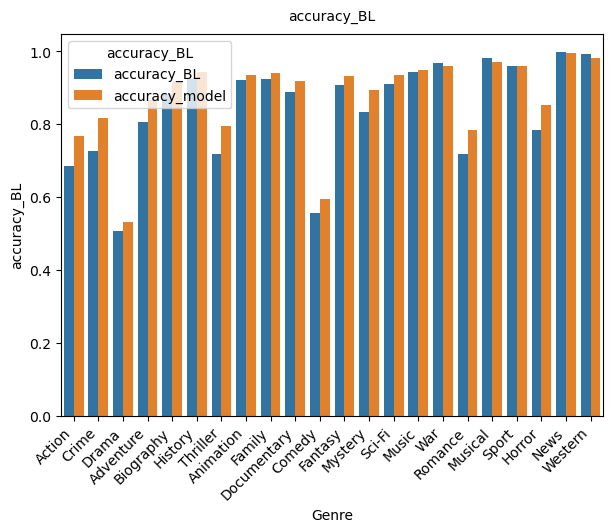

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


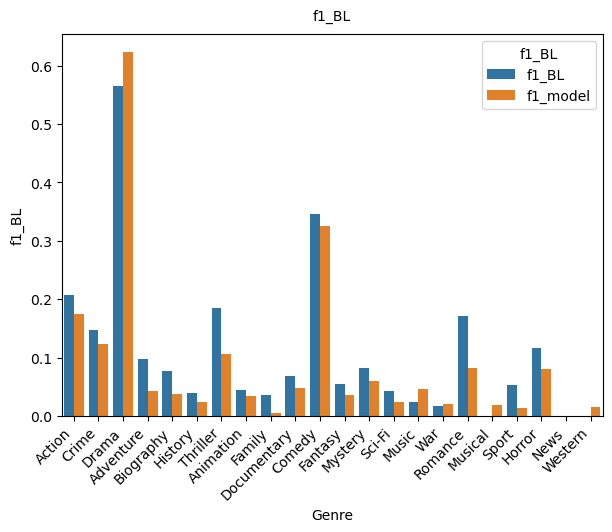

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


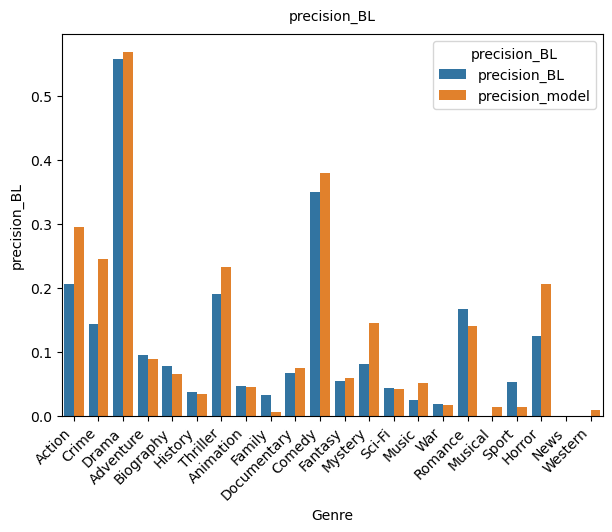

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


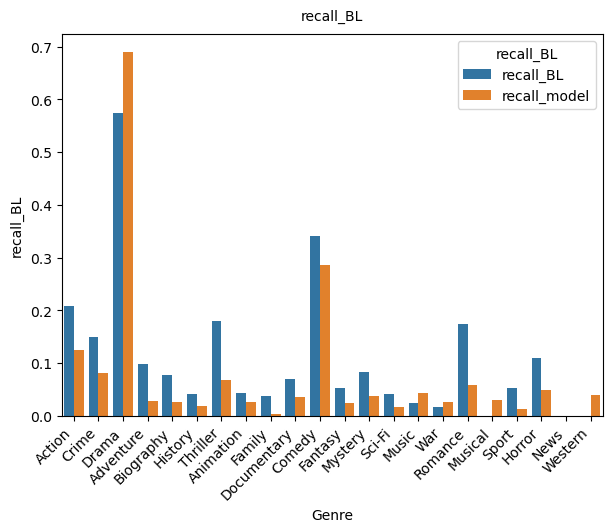

In [24]:
myplot(performent_LR, performent_BL, 0)
myplot(performent_LR, performent_BL, 1)
myplot(performent_LR, performent_BL, 2)
myplot(performent_LR, performent_BL, 3)

Sử dụng Random Forest

In [ ]:
# Random forest

X_train = train['convert_image'].tolist()
X_test = test['convert_image'].tolist() 
model_RF = RandomForestClassifier(n_estimators=100, random_state=42)
performent_RF = {}
for index, i in enumerate(Genre):
    y_train = train[i]
    y_test = test[i]

    # Huấn luyện mô hình trên tập huấn luyện
    model_RF.fit(X_train, y_train)

    # Dự đoán nhãn cho tập kiểm tra
    y_pred = model_RF.predict(X_test)

    # Đánh giá độ chính xác
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    performent_RF[i] = {'accuracy_RF':accuracy, 'f1_RF' : f1, 'precision_RF' : precision, 'recall_RF':recall}
print(performent_RF)

C:\Users\PC\AppData\Local\Temp\ipykernel_30620\1599518971.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pb.iloc[0])
C:\Users\PC\AppData\Local\Temp\ipykernel_30620\1599518971.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(p_RF.iloc[0])


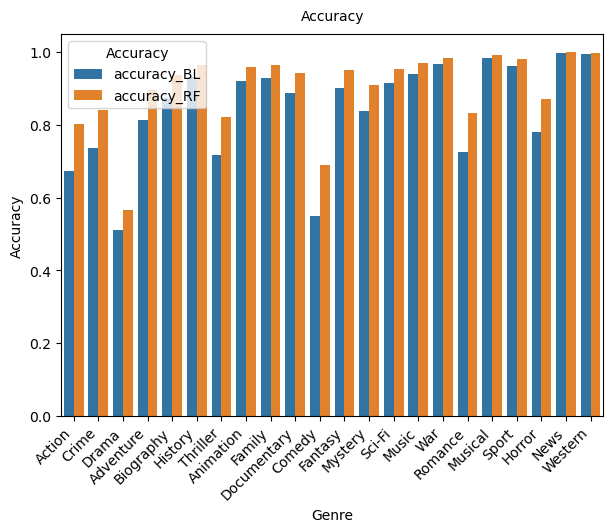

In [103]:
myplot(performent_RF, performent_BL, 0)
myplot(performent_RF, performent_BL, 1)
myplot(performent_RF, performent_BL, 2)
myplot(performent_RF, performent_BL, 3)

In [95]:
X_train = train['pixel_matrix'].tolist()
X_test = test['pixel_matrix'].tolist() 
model_SVC = skl_svm.LinearSVC()
performent_SVC = {}
Y_pred = {}
for index, i in enumerate(Genre):
    y_train = train[i]
    y_test = test[i]

    # Huấn luyện mô hình trên tập huấn luyện
    model_SVC.fit(X_train, y_train)

    # Dự đoán nhãn cho tập kiểm tra
    y_pred = model_SVC.predict(X_test)
    Y_pred[i] = y_pred

    # Đánh giá độ chính xác
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    performent_SVC[i] = {'accuracy_SVC':accuracy, 'f1_SVC' : f1, 'precision_SVC' : precision, 'recall_SVC':recall}
print(performent_SVC)

c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change 

{'Action': {'accuracy_SVC': 0.7907204934118307, 'f1_SVC': 0.07209446861404599, 'precision_SVC': 0.29292929292929293, 'recall_SVC': 0.041105598866052445}, 'Crime': {'accuracy_SVC': 0.8002523128679563, 'f1_SVC': 0.12415488629379223, 'precision_SVC': 0.2, 'recall_SVC': 0.09001782531194295}, 'Drama': {'accuracy_SVC': 0.44014578076815253, 'f1_SVC': 0.05310573731626363, 'precision_SVC': 0.48068669527896996, 'recall_SVC': 0.028105395232120453}, 'Adventure': {'accuracy_SVC': 0.8530978413232408, 'f1_SVC': 0.06595365418894832, 'precision_SVC': 0.09973045822102426, 'recall_SVC': 0.0492676431424767}, 'Biography': {'accuracy_SVC': 0.8274460330810205, 'f1_SVC': 0.07094339622641509, 'precision_SVC': 0.053591790193842644, 'recall_SVC': 0.10491071428571429}, 'History': {'accuracy_SVC': 0.9165965797589011, 'f1_SVC': 0.0449438202247191, 'precision_SVC': 0.03910614525139665, 'recall_SVC': 0.052830188679245285}, 'Thriller': {'accuracy_SVC': 0.5287356321839081, 'f1_SVC': 0.2565236620964175, 'precision_SVC':

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


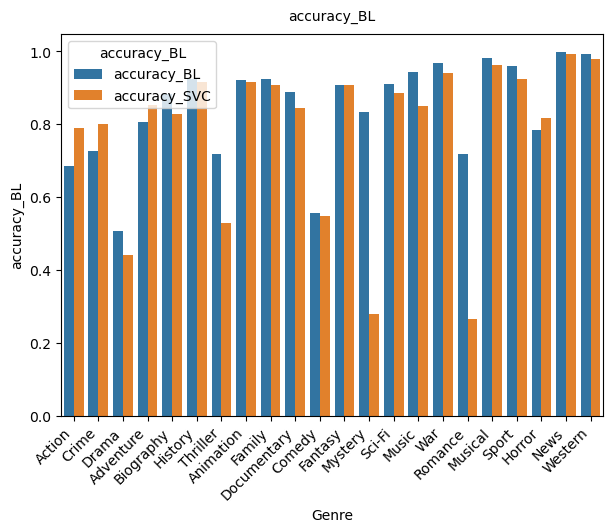

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


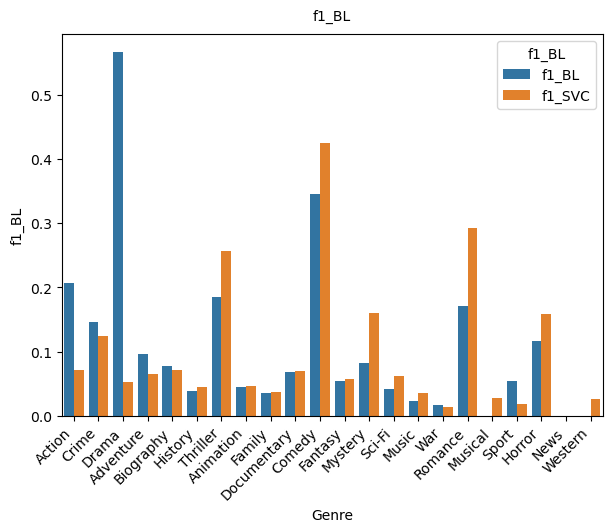

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


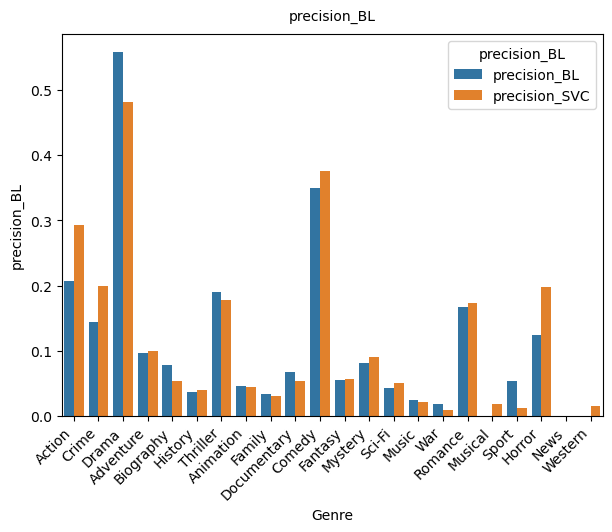

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


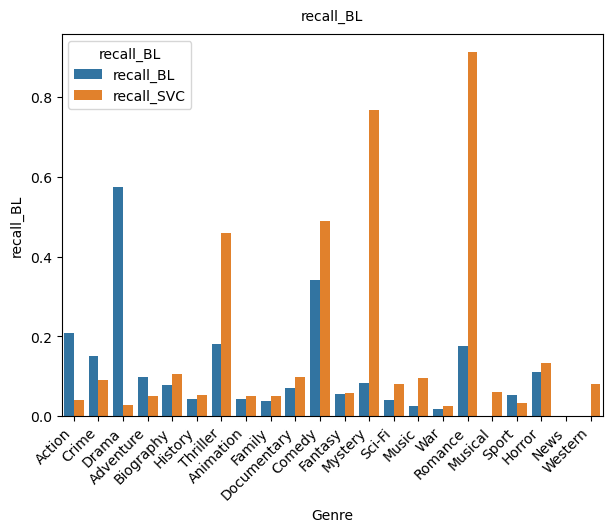

In [96]:
myplot(performent_SVC, performent_BL, 0)
myplot(performent_SVC, performent_BL, 1)
myplot(performent_SVC, performent_BL, 2)
myplot(performent_SVC, performent_BL, 3)

Cải thiện mô hình dự đoán

Dự đoán nhiều Genre cùng 1 lúc

<!--  -->

In [104]:
# chọn model
def set_model(genre):
    # các điều kiện
    model = skl_lm.LogisticRegression(solver='lbfgs')
    return model

In [105]:
# mô hình nhà máy, dự đoán từng genre một
model = {}
for index, i in enumerate(Genre):
    model[i] = set_model(i)

X_train = train['pixel_matrix'].tolist()

for index, i in enumerate(Genre):
    
    model_i = model[i]

    Y_train = train[i]

    model_i.fit(X_train, Y_train)

c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [106]:
X_test = test['pixel_matrix'].to_list()
Y_test = test['vector_oneshot'].to_list()

# predict, đánh giá hiệu suất:
y_hat = []

for genre in Genre:
    yi_hat = model[genre].predict(X_test)
    
    y_hat.append(yi_hat)
y_hat = np.transpose(y_hat)
# print(accuracy_score(y_hat, Y_test))

In [107]:
def my_accuracy(y_hat, Y_test):
    count = 0
    for index,i in enumerate(y_hat):
        if y_hat[index] == Y_test[index]:
            count += 1
    return count / len(y_hat)

In [108]:
print(my_accuracy(y_hat.tolist(), Y_test))

0.0496215306980656


c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

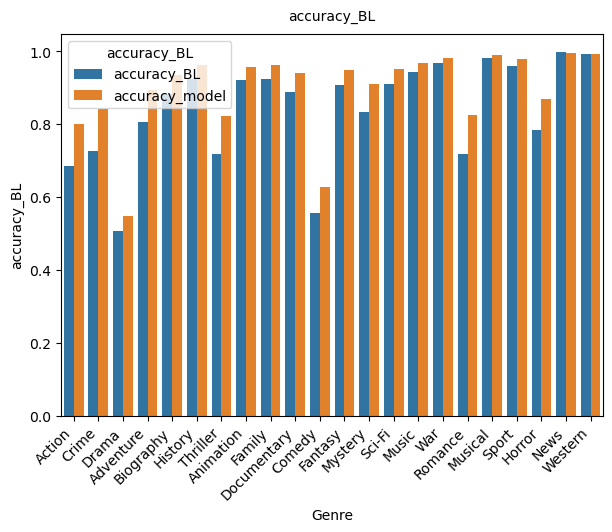

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


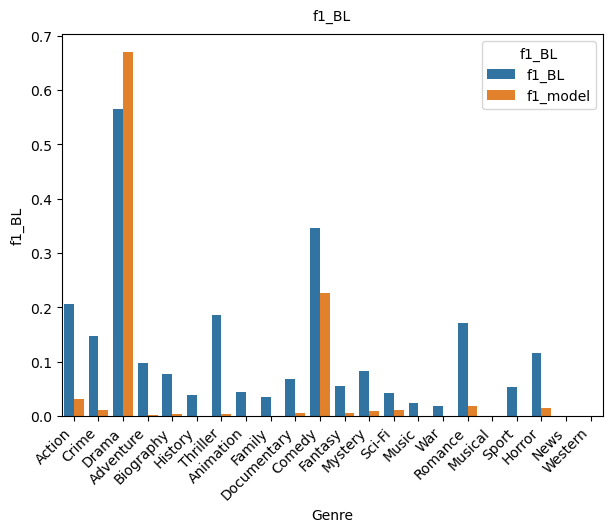

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


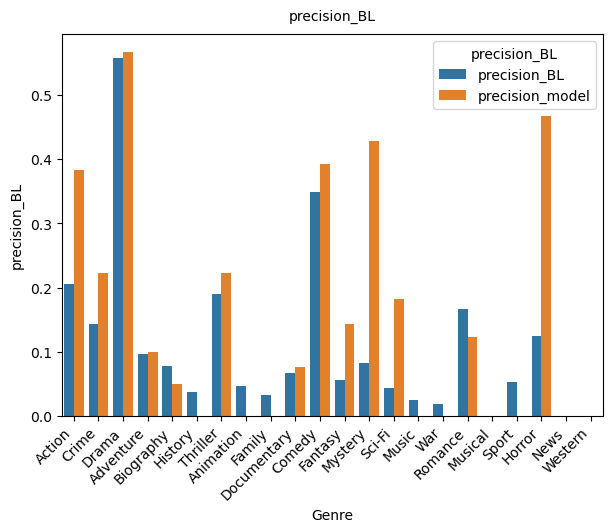

C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p_BL.iloc[input])
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1021947377.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(p.iloc[input])


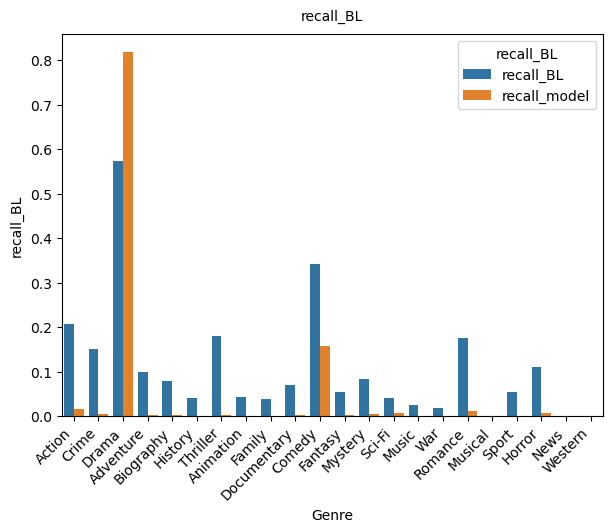

In [75]:
# thêm dữ liệu
performent, y_pred = model_Logistic(train, test, 'convert_image')
myplot(performent, performent_BL, 0)
myplot(performent, performent_BL, 1)
myplot(performent, performent_BL, 2)
myplot(performent, performent_BL, 3)

In [87]:
# smoteen 
X = df['convert_image'].to_list()
y = df['Action']
print(Counter(y))
sampler = SMOTEENN(random_state=42, sampling_strategy={1:12000,1:12000})
X_sampling, y_sampling = sampler.fit_resample(X,y)
print(Counter(y_sampling))

Counter({0.0: 19025, 1.0: 4753})
Counter({1.0: 9286, 0.0: 6737})


In [88]:
np.random.seed(100)
index = np.random.choice(np.arange(len(X_sampling)),int(0.7*len(X_sampling)),replace=False)
indexI = np.isin(np.arange(len(X_sampling)), index)
X_train = [x for x, mask in zip(X_sampling, indexI) if mask]
X_test = [x for x, mask in zip(X_sampling, ~indexI) if mask]

y_train = [x for x, mask in zip(y_sampling, indexI) if mask]
y_test = [x for x, mask in zip(y_sampling, ~indexI) if mask]

model = skl_lm.LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

performent_c = {}
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
performent_c = {'accuracy_RF':accuracy, 'f1_RF' : f1, 'precision_RF' : precision, 'recall_RF':recall}

print(my_confusion_matrix(y_test, y_pred))
print(performent_c)
print(performent['Action'])

            y_test = -1  y_test = 1
y_hat = -1         1161         830
y_hat = 1           883        1933
{'accuracy_RF': 0.6436446848346162, 'f1_RF': 0.6929557268327656, 'precision_RF': 0.6864346590909091, 'recall_RF': 0.6996018820123054}
{'accuracy_model': 0.8002523128679563, 'f1_model': 0.03127124405166554, 'precision_model': 0.38333333333333336, 'recall_model': 0.01630049610205528}


c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
print('Action')
my_confusion_matrix(y_test, y_pred)

Action


,y_test = -1,y_test = 1
y_hat = -1,1157,564
y_hat = 1,692,2159


In [201]:
print(accuracy_score(y_test, y_pred))

0.6436446848346162


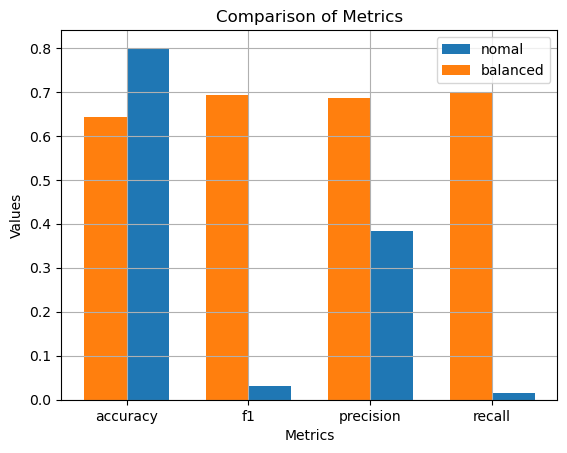

In [92]:
# so sánh các metric trước và sau khi thêm dữ liệu từ ảnh
import matplotlib.pyplot as plt
import numpy as np

# Hai từ điển chứa các giá trị
dict1 = performent_c
dict2 = performent['Action']

# Tạo danh sách các giá trị x
x = ['accuracy', 'f1', 'precision', 'recall']

# Tạo danh sách giá trị y từ hai từ điển
y1 = [dict1['accuracy_RF'], dict1['f1_RF'], dict1['precision_RF'], dict1['recall_RF']]
y2 = [dict2['accuracy_model'], dict2['f1_model'], dict2['precision_model'], dict2['recall_model']]

# Tạo mảng chỉ số cho các cột
index = np.arange(len(x))

# Độ rộng của mỗi cột
width = 0.35

# Vẽ biểu đồ cột

plt.bar(index + width, y2, width, label='nomal')
plt.bar(index, y1, width, label='balanced')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Metrics')
plt.xticks(index + width/2, x)
plt.legend()
plt.grid(True)

plt.show()

In [126]:
df_count = pd.DataFrame(columns=['0','1','name'])
for i in Genre:
    a = Counter(df[i])
    df_count = df_count.append({'0':a[0],'1':a[1],'name':i}, ignore_index=True)

19025
19967
10384
21309
22240
22836
19657
22837
22867
22343
15768
22567
21680
22696
23068
23358
19894
23558
23271
20813
23749
23689


C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1809292602.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_count = df_count.append({'0':a[0],'1':a[1],'name':i}, ignore_index=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1809292602.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_count = df_count.append({'0':a[0],'1':a[1],'name':i}, ignore_index=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1809292602.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_count = df_count.append({'0':a[0],'1':a[1],'name':i}, ignore_index=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_19992\1809292602.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

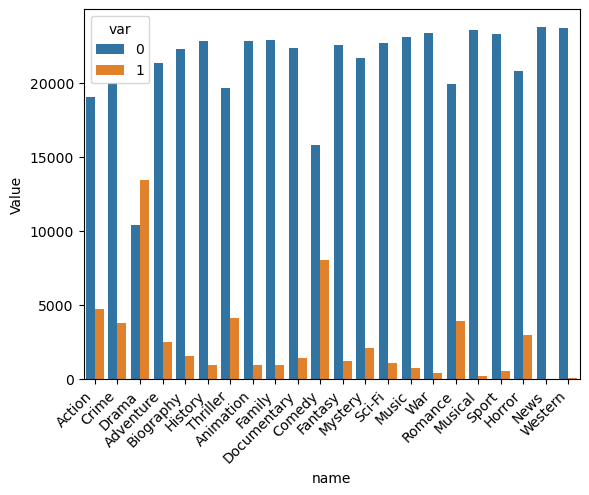

In [131]:
df_long = pd.melt(df_count ,id_vars='name', var_name= 'var', value_name='Value')
sns.barplot(data = df_long, x='name', y='Value', hue= 'var')
plt.xticks(rotation=45, ha='right')
plt.show()